<a href="https://colab.research.google.com/github/andresenrique08/ML_2020/blob/master/Proyecto_Malware/Malware_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de Malware

**Curso de Machine Learning 2020-20**

*Proyecto Final*

Autores:


*   Andrés Enrique Ávila Rojas (201319127)
*   Jeison Alexander Timana Rangel (201617870)

Descripción de lo que se hace en el notebook...



In [37]:
# Importing libraries
import numpy as np
import pydrive as drive
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)

# Modulos para contingencias
from scipy.stats import chi2
from scipy.stats import chi2_contingency

Se dan los permisos para acceder al almecenamiento de drive.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Preparación de los datos

En esta sección se presenta la lectura y análisis preliminar de los datos de entrenamiento y los datos de validación. Estos datos vienen en dos archivos de formato csv separado por comas y pueden ser obtenidos de la página de la  <a href="https://www.kaggle.com/c/microsoft-malware-prediction/data">competencia de microsoft para la dección de malware</a> disponible en kaggle. El peso de los conjuntos de datos es:


*   train.csv: 4.08 GB
*   test.csv: 3.53 GB



**Datos de entrenamiento**

In [3]:
%%time
ruta_train = '/content/drive/MyDrive/Machine Learning/train.csv'
train  = pd.read_csv(ruta_train) 

<string>:2: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 27s, sys: 15.5 s, total: 1min 42s
Wall time: 1min 50s


In [4]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,...,HDD,299451.0,0,4096.0,Desktop,18.9,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,...,HDD,102385.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4909.0,317701.0,4.0,5.0,...,SSD,113907.0,0,4096.0,Desktop,21.5,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,142.0,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,88,20710.0,NaN,117.0,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,...,UNKNOWN,227116.0,0,4096.0,MiniTower,18.5,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,355.0,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417e

In [ ]:
train.shape

(8921483, 83)

Se observan los valores únicos de la variable de salida.

In [ ]:
train.HasDetections.unique()

array([0, 1])

La variable objetivo ```HasDectections``` sólo tiene dos valores. Donde 1 indica que se ha detectado un Malware y 0 indica que no se detectó Malware.

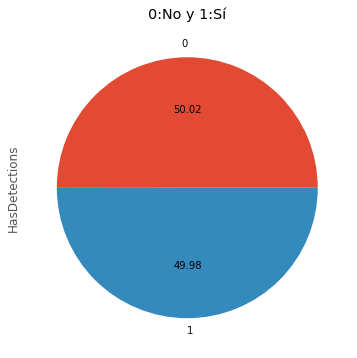

In [ ]:
train.HasDetections.value_counts().plot(kind='pie',figsize=(6, 6),title='0:No y 1:Sí',autopct='%.2f')

Se observa que los datos de la variable objetivo están balanceados.

**Datos de validación**

In [ ]:
%%time
ruta_test = '/content/drive/MyDrive/Machine Learning/test.csv'
test  = pd.read_csv(ruta_test) 

<string>:2: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 1min 21s, sys: 16.3 s, total: 1min 37s
Wall time: 1min 46s


In [ ]:
test.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,0000010489e3af074adeac69c53e555e,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,43,58552.0,18.0,53.0,42,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,NaN,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2689.0,30661.0,4.0,5.0,...,488386.0,SSD,123179.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,8.0,10.0.15063.1387,amd64,rs2_release,15063,1387,Core,CORE,Reset,37.0,158,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,807.0,8554.0,1,NaN,0.0,0,0,0.0,0.0,7.0
1,00000176ac758d54827acd545b6315a5,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,68,71395.0,NaN,276.0,74,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,242491.0,4.0,5.0,...,1907729.0,HDD,1882352.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,NaN,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,Core,CORE,UUPUpgrade,7.0,30,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,554.0,33105.0,1,NaN,0.0,0,0,0.0,1.0,12.0
2,0000019dcefc128c2d4387c1273dae1d,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,NaN,49480.0,2.0,1.0,1,201,66202.0,NaN,267.0,251,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,NaN,NaN,98.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,...,29820.0,SSD,28678.0,0,4096.0,Notebook,13.9,1280.0,720.0,Mobile,NaN,0.0,10.0.14393.2189,amd64,rs1_release,14393,2189,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,35.0,148,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,556.0,63396.0,1,NaN,0.0,0,0,0.0,1.0,11.0
3,0000055553dc51b1295785415f1a224d,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,NaN,42160.0,2.0,1.0,1,29,120917.0,NaN,35.0,171,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,NaN,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171228.0,2.0,5.0,...,476940.0,HDD,439345.0,0,4096.0,Notebook,14.0,1366.0,768.0,Mobile,li-i,0.0,10.0.16299.371,amd64,rs3_release,16299,371,CoreSingleLanguage,CORE_SINGLELANGUAGE,Upgrade,26.0,119,Notify,0,IS_GENUINE,OEM:D

In [ ]:
test.shape

(7853253, 82)

Preliminarmente se puede analizar que los conjuntos de datos de entrenamiento y de validación no tienen la misma cantidad de variables (Como se observa en la siguiente tabla). En este caso es fácil identificar que en los datos de validación no cuentan con la variable objetivo ```HasDetections``` por lo que no sería muy útil usarlos en la validación y evaluación del modelo propuesto.

Dataframe | No. de datos | No. de Variables |
----------|--------------|------------------|
Train | 8.921.483 | 83 |
Test | 7.853.253 | 82 |

Sin embargo, se indagó en la página de la <a href="https://www.kaggle.com/c/microsoft-malware-prediction/data">competencia de microsoft para la dección de malware</a> y se encontró otra base de datos disponibles, parece ser la columna de detección de malware con la variable que hace falta en el conjunto test, sin embargo como se observa en la siguiente figura, esta columna solo tiene valores iguales a 0.5, y corresponden a los valores que deben ser actualizados por los participantes de la competencia.

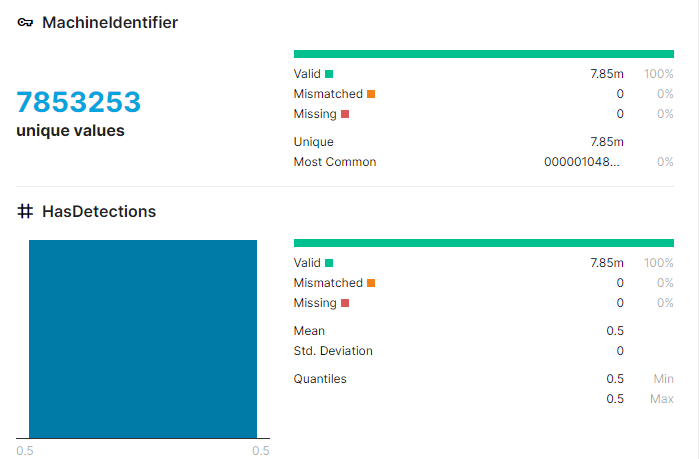


Debido a esto, sólo se usará el dataframe de train, la cual se dividirá para obtener los datos de validación y de entrenamiento, mediante la función ```train_test_split``` de scikit-learn. Mientras que el dataframe de test cargado en este notebook se eliminará.

In [ ]:
del test

## Etapa de preprocesamiento de los datos

En esta sección se busca realizar las modificaciones y la limpieza necesaria de los datos para la inclusión en los modelos a probar y desarrollar posteriormente. Algunos de los puntos principales que se realizan en esta etapa son:


*   Revisar si hay filas de datos duplicadas o redundantes que puedan considerarse obsoletas en el modelo.
*   Analizar los datos nulos o perdidos dentro de la base de datos, y tomar decisiones respecto al manejo que se les darán.
*   Analizar la existencia de datos atípicos por cada una de las columnas de datos disponibles para los análisis. 
*   Revisar la oblicuidad de la distribución de los datos, analizando el porcentaje más alto que puede tener una característica o valor único dentro de cada variable.
*   Hacer las transformaciones necesarias de los datos para que puedan ser utilizados dentro de los modelos. 



### Limpieza de datos

Inicialmente se verifica la existencia de filas duplicadas.

In [ ]:
train.duplicated().sum()

0

Se observa que dentro de la data disponible no existen datos repetidos. 

A continuación se presenta una tabla con información relevante para el análisis y limpieza de datos. En esta se presenta el porcentaje de datos nulos para cada variable, el porcentaje de ceros que existen, el tipo de datos, el número de valores únicos de cada variable, y la categoria de la variable con el mayor porcentaje de datos repetidos (buscando un análisis de la distribución estadística de los datos)

In [5]:
def mytable(data):
    stats = []
    for col in data.columns:
        stats.append((col, data[col].isnull().sum()/data.shape[0]*100, (data[col]==0).sum()/data.shape[0]*100, 
                      data[col].dtype,data[col].nunique(),data[col].value_counts(normalize=True, dropna=False).values[0] * 100))
        
    mis_val_table = pd.DataFrame(stats, columns=['Variable','% de datos nulos','% de ceros','Tipo de datos','# de valores diferentes','% de la categoria con más datos'])
    return mis_val_table

In [ ]:
stats_train = mytable(train)
stats_train = stats_train.sort_values(by=['% de datos nulos'], ascending = False)
stats_train

,Variable,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de la categoria con más datos
28,PuaMode,99.974119,0.000000,object,2,99.974119
41,Census_ProcessorClass,99.589407,0.000000,object,3,99.589407
8,DefaultBrowsersIdentifier,95.141637,0.000000,float64,2017,95.141637
68,Census_IsFlightingInternal,83.044030,16.955735,float64,2,83.044030
52,Census_InternalBatteryType,71.046809,0.000000,object,78,71.046809
71,Census_ThresholdOptIn,63.524472,36.466381,float64,2,63.524472
75,Census_IsWIMBootEnabled,63.439038,36.560951,float64,2,63.439038
31,SmartScreen,35.610795,0.000000,object,21,48.379658
15,OrganizationIdentifier,30.841487,0.000000,float64,49,47.037662
29,SMode,6.027686,93.928812,float64,2,93.928812


Teniendo en cuenta la organización dada a la tabla, donde se organiza de mayor porcentaje de datos perdidos al menor, se puede analizar lo siguiente: 

*  Las variable ```PuaMode```, ```Census_ProcessorClass``` y ```DefaultBrowsersIdentifier``` tiene un porcentaje de datos perdidos superior al 90%.
*  Algunas variables tienen entre sus datos no nulos altos porcentajes de ceros. En algunos casos se tiene que la suma del porcentaje de datos nulos y de datos iguales es mayor al 99%, lo que nos podría decir que estas variables pueden ser ignoradas del análisis puesto que no brindan mucha información. Estás variables son: ```Census_ThresholdOptIn```, ```Census_IsWIMBootEnabled```, ```SMode```, ```Census_IsFlightingInternal```, ```Census_IsFlightsDisabled```, ```Census_IsVirtualDevice```, ```Census_IsPortableOperatingSystem```, ```IsBeta```, ```IsSxsPassiveMode```,```AutoSampleOptIn```.
* Teniendo en cuenta que no es posible completar la información de los datos perdidos, con el fin de no perder un alto porcentaje de datos, se decide eliminar las variables con un porcentaje de datos perdidos superior al 30%, en este caso son: ```Census_InternalBatteryType```, ```SmartScreen```, ```OrganizationIdentifier```.
*  La variable ```MachineIdentifier``` tiene 8.921.483 de valores únicos, lo que quiere decir que hay un valor diferente por cada fila de datos, por lo que también podría ser eliminada puesto que no brinda información relevante para el problema, puesto que el Malware debe ser detectado sin importar la máquina que se esté evaluando.

De esta manera se propone realizar la eliminación de estas variables. Justificando que no aportan información relevante para el modelo.

In [6]:
A_eliminar1 = ['PuaMode','Census_ProcessorClass','DefaultBrowsersIdentifier','Census_ThresholdOptIn','Census_IsWIMBootEnabled','SMode','Census_IsFlightingInternal'
        ,'Census_IsFlightsDisabled','Census_IsVirtualDevice','Census_IsPortableOperatingSystem','IsBeta','IsSxsPassiveMode','AutoSampleOptIn'
        ,'Census_InternalBatteryType','SmartScreen','OrganizationIdentifier','MachineIdentifier']
        
for rem in A_eliminar1:
  train = train.drop(rem, axis=1)

Una vez eliminadas estas columnas se verifica el nuevo tamaño del data frame, observando que ahora quedan 66 variables para nuestro análisis. 

In [7]:
train.shape

(8921483, 66)

Con esto en mente, se procede a eliminar las filas que contengan datos nulos.

In [8]:
train = train.dropna()

Obteniendo así 7.659.039 datos, lo que quiere decir que 1.262.444 filas de datos fueron eliminadas del dataset.

In [9]:
train.shape

(7659039, 66)

A continuación se verificará nuevamente la calidad de los datos con la tabla presentada anteriormente, en esta oportunidad se organizará por aquellas que tengan un alto porcentaje de desbalance en sus características, comparando así la oblicuidad de la distribución de los datos de cada variable.

In [ ]:
stats_train = mytable(train)
stats_train = stats_train.sort_values(by=['% de la categoria con más datos'], ascending = False)
stats_train

,Variable,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de la categoria con más datos
26,Census_DeviceFamily,0.0,0.000000,object,3,99.999896
0,ProductName,0.0,0.000000,object,4,99.919624
8,HasTpm,0.0,0.171758,int64,2,99.828242
24,UacLuaenable,0.0,0.444377,float64,10,99.552568
13,Platform,0.0,0.000000,object,3,98.373712
15,OsVer,0.0,0.000000,object,45,98.367550
23,Firewall,0.0,2.039277,float64,2,97.960723
7,AVProductsEnabled,0.0,0.252930,float64,6,97.582373
4,RtpStateBitfield,0.0,2.196085,float64,7,97.296240
61,Census_IsPenCapable,0.0,96.003180,int64,2,96.003180


Analizando la tabla se observa que 17 variables tienen una de sus categorias de valores únicos más del 90% de los datos. Esto muestra un desbalance en los datos que puede ocasionar que el modelo de clasificación usado para este problema tome las características de menor presencia en las variables como ruido para el modelo, por lo que se podrían presentar errores en la clasificación de las características de menos presencia con respecto a las que tienen mayor porcentaje de aparición. En este sentido, se decide eliminar aquellas variables que presenten altos desbalances, es decir, aquellas que tengan más del 90% del total de datos en un solo valor. Estas son: ```Census_DeviceFamily```, ```ProductName```, ```HasTpm```, ```UacLuaenable```, ```Platform```, ```OsVer```, ```Firewall```, ```AVProductsEnabled```, ```RtpStateBitfield```, ```Census_IsPenCapable```, ```IsProtected```, ```Census_IsAlwaysOnAlwaysConnectedCapable```, ```Census_FlightRing```, ```Census_HasOpticalDiskDrive```, ```Census_OSArchitecture```, ```Processor```, ```Census_GenuineStateName```.

In [10]:
good_cols = list(train.columns)
cont = 1
for col in train.columns:
    rate = train[col].value_counts(normalize=True).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(str(cont)+'. Se eliminó la columna '+ col)
        cont += 1

1. Se eliminó la columna ProductName
2. Se eliminó la columna RtpStateBitfield
3. Se eliminó la columna AVProductsEnabled
4. Se eliminó la columna HasTpm
5. Se eliminó la columna Platform
6. Se eliminó la columna Processor
7. Se eliminó la columna OsVer
8. Se eliminó la columna IsProtected
9. Se eliminó la columna Firewall
10. Se eliminó la columna UacLuaenable
11. Se eliminó la columna Census_DeviceFamily
12. Se eliminó la columna Census_HasOpticalDiskDrive
13. Se eliminó la columna Census_OSArchitecture
14. Se eliminó la columna Census_GenuineStateName
15. Se eliminó la columna Census_FlightRing
16. Se eliminó la columna Census_IsPenCapable
17. Se eliminó la columna Census_IsAlwaysOnAlwaysConnectedCapable


In [11]:
train = train[good_cols]

Se verifica el nuevo número de variables para el ejercicio. Obteniéndose 49 variables, entre las cuales se incluye la variable objetivo ```HasDetections```

In [12]:
train.shape

(7659039, 49)

Se procede a verificar nuevamente la calidad de los datos mediante la tabla anterior.

In [ ]:
stats_train = mytable(train)
stats_train

,Variable,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de la categoria con más datos
0,EngineVersion,0.0,0.000000,object,65,42.775118
1,AppVersion,0.0,0.000000,object,104,60.089405
2,AvSigVersion,0.0,0.000000,object,8474,1.184222
3,AVProductStatesIdentifier,0.0,0.000000,float64,25390,64.970671
4,AVProductsInstalled,0.0,0.000000,float64,7,68.410071
5,CountryIdentifier,0.0,0.000000,int64,222,4.292392
6,CityIdentifier,0.0,0.000000,float64,103879,1.140770
7,GeoNameIdentifier,0.0,0.000000,float64,290,16.923977
8,LocaleEnglishNameIdentifier,0.0,0.000000,int64,275,23.363949
9,OsBuild,0.0,0.000000,int64,71,45.027516


Con el fin de dar inicio al análisis exploratorio de los datos, se divide los datos de tipo numericos y categoricos.

In [13]:
categorical_data = train.select_dtypes('object')
categorical_data.shape

(7659039, 17)

In [14]:
numerical_data = train.select_dtypes(exclude='object')
numerical_data.shape

(7659039, 32)

Se obtiene que en el dataframe resultante tenemos 17 variables categoricas y 32 variables numericas. A simple vista se puede notar que algunas de las variables numericas son identificadores de alguna característica, por lo que deberían ser considerados como variables categoricas nominales, puesto que no tienen un peso que haga una característica más importante que otra y no puede ser categorizada numericamente. Este análisis será profundizado en el análisis exploratorio de los datos. 

### Análisis Exploratorio de los Datos (EDA)

Lo primero a determinar es cuales de las variables de tipo numerico actualmente deberían considerarse como categoricas nominales, pues representan a identificadores sin orden numerico especifico. De esta manera, se analiza la tabla de calidad de datos que se viene utilizando este documento.

In [ ]:
numerical_data.head()

,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IeVerIdentifier,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,53447.0,1.0,29,128035.0,35.0,171,17134,256,137.0,2668.0,9124.0,4.0,5.0,2341.0,476940.0,299451.0,4096.0,18.9,1440.0,900.0,4.294967e+09,17134,165,26.0,119,628.0,36144.0,0,0,0.0,10.0,0
1,53447.0,1.0,93,1482.0,119.0,64,17134,256,137.0,2668.0,91656.0,4.0,5.0,2405.0,476940.0,102385.0,4096.0,13.9,1366.0,768.0,1.000000e+00,17134,1,8.0,31,628.0,57858.0,0,0,0.0,8.0,0
2,53447.0,1.0,86,153579.0,64.0,49,17134,768,137.0,4909.0,317701.0,4.0,5.0,1972.0,114473.0,113907.0,4096.0,21.5,1920.0,1080.0,4.294967e+09,17134,165,7.0,30,142.0,52682.0,0,0,0.0,3.0,0
3,53447.0,1.0,88,20710.0,117.0,115,17134,256,137.0,1443.0,275890.0,4.0,5.0,2273.0,238475.0,227116.0,4096.0,18.5,1366.0,768.0,4.294967e+09,17134,228,17.0,64,355.0,20050.0,0,0,0.0,3.0,1
4,53447.0,1.0,18,37376.0,277.0,75,17134,768,137.0,1443.0,331929.0,4.0,5.0,2500.0,476940.0,101900.0,6144.0,14.0,1366.0,768.0,0.000000e+00,17134,191,8.0,31,355.0,19844.0,0,0,0.0,1.0,1


In [ ]:
stats_numerical = mytable(numerical_data)
stats_numerical

,Variable,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de la categoria con más datos
0,AVProductStatesIdentifier,0.0,0.000000,float64,25390,64.970671
1,AVProductsInstalled,0.0,0.000000,float64,7,68.410071
2,CountryIdentifier,0.0,0.000000,int64,222,4.292392
3,CityIdentifier,0.0,0.000000,float64,103879,1.140770
4,GeoNameIdentifier,0.0,0.000000,float64,290,16.923977
5,LocaleEnglishNameIdentifier,0.0,0.000000,int64,275,23.363949
6,OsBuild,0.0,0.000000,int64,71,45.027516
7,OsSuite,0.0,0.000000,int64,4,63.852267
8,IeVerIdentifier,0.0,0.000000,float64,213,45.027307
9,Census_OEMNameIdentifier,0.0,0.000000,float64,3384,14.842280


De esta manera, se identifican las siguientes variables que deben ser tratadas como variables categoricas nominales: ```AVProductStatesIdentifier```, ```CountryIdentifier```, ```CityIdentifier```, ```GeoNameIdentifier```, ```LocaleEnglishNameIdentifier```, ```IeVerIdentifier```,```Census_OEMNameIdentifier```,```Census_OEMModelIdentifier```,```Census_ProcessorManufacturerIdentifier```, ```Census_ProcessorModelIdentifier```, ```Census_OSInstallLanguageIdentifier```, ```Census_OSUILocaleIdentifier```, ```Census_FirmwareManufacturerIdentifier```,```Census_FirmwareVersionIdentifier```,```Wdft_RegionIdentifier```.

Haciendose necesaria la transformación 15 variables numericas a categoricas, teniendo en cuenta que son identificadores (ID) para alguna característica de las variables.

In [15]:
to_cat = ['AVProductStatesIdentifier','CountryIdentifier','CityIdentifier','GeoNameIdentifier','LocaleEnglishNameIdentifier'
          ,'IeVerIdentifier','Census_OEMNameIdentifier','Census_OEMModelIdentifier','Census_ProcessorManufacturerIdentifier'
          ,'Census_ProcessorModelIdentifier','Census_OSInstallLanguageIdentifier','Census_OSUILocaleIdentifier'
          ,'Census_FirmwareManufacturerIdentifier','Census_FirmwareVersionIdentifier','Wdft_RegionIdentifier']

for var in to_cat:
  train[var] = train[var].astype('object')

De esta manera, se obtienen los nuevos conjuntos de variables categoricas y numéricas. 

In [16]:
categorical_data = train.select_dtypes('object')
categorical_data.shape

(7659039, 32)

In [17]:
numerical_data = train.select_dtypes(exclude='object')
numerical_data.shape

(7659039, 17)

El nuevo numero de variables categoricas es 32, mientras que sólo hay 17 variables númericas, en la que se incluye la variable objetivo.

#### Análisis de variables númericas

Primero se analiza cual de las variables presenta valores atípicos, es decir observaciones que se encuentren alejadas de las otras observaciones. Para ello se graficará los diagramas de cajas los cuales permiten una representación grafica de los grupos de datos numericos através de sus cuartiles estadísticos. Los datos atípicos son gráficados como puntos individuales fuera de las cajas que representa el comportamiento dentro de los cuartiles.

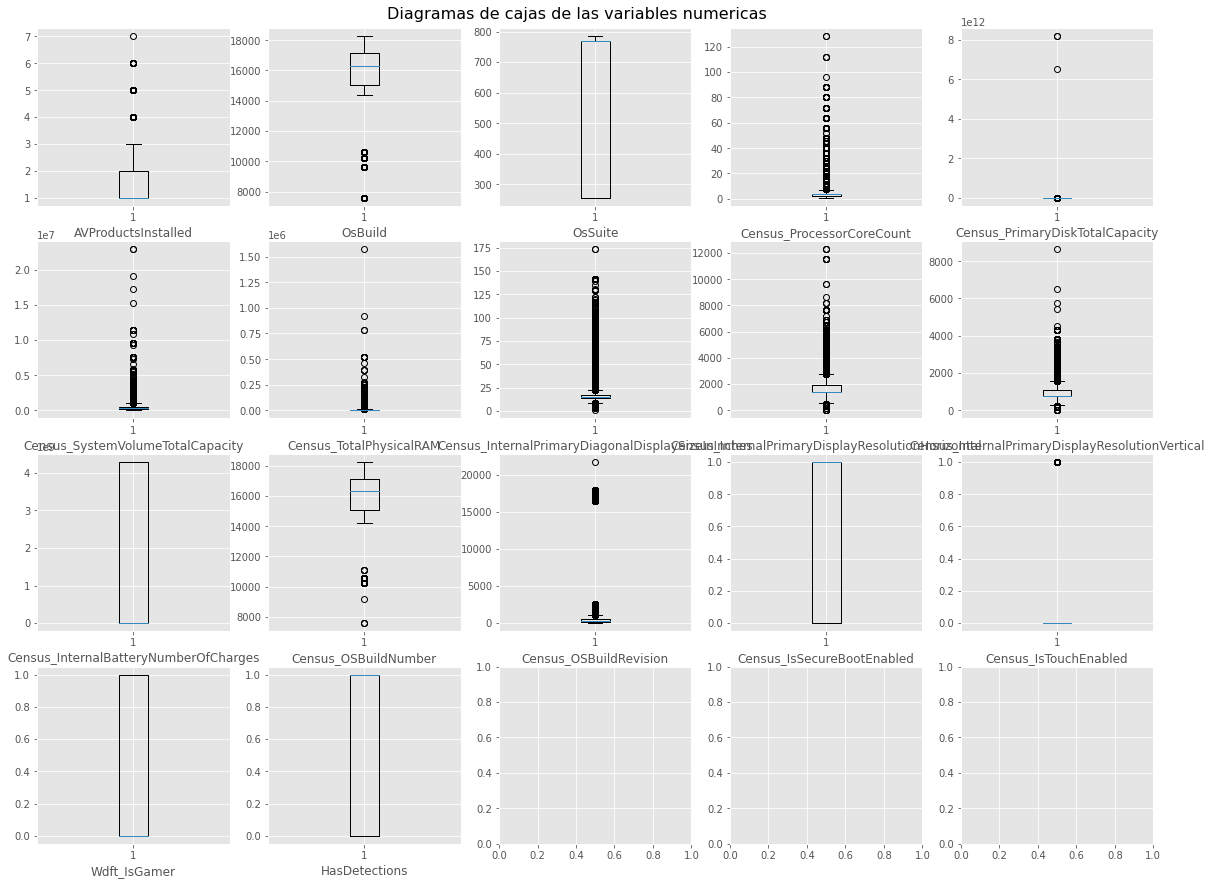

In [18]:
f, axarr = plt.subplots(4, 5, figsize=(20,15))
f.suptitle('Diagramas de cajas de las variables numericas', y=0.9, fontsize=16)

c = 0
for i in range(4):
  for j in range(5):
    if c==numerical_data.shape[1]:
      break
    dat = numerical_data.iloc[:,c]
    axarr[i,j].boxplot(x=dat)
    axarr[i,j].set_xlabel(dat.name)
    c += 1    

Se puede observar que sólo 5 variables (```OsSuite```, ```Census_InternalBatteryNumberOfCharges```, ```Census_IsSecureBootEnabled```, ```Wdft_IsGamer```, ```HasDetections```) nos presentaron valores atípicos en sus muestras. En las demás variables se detectaron datos atípicos, sin embargo, parece ser necesario tenerlos en cuenta debido a que pueden presentar información relevante para el estudio, mostrando características diferentes para algunas de las máquinas evaluadas.

A continuación se analiza la correlación lineal entre las variables númericas.

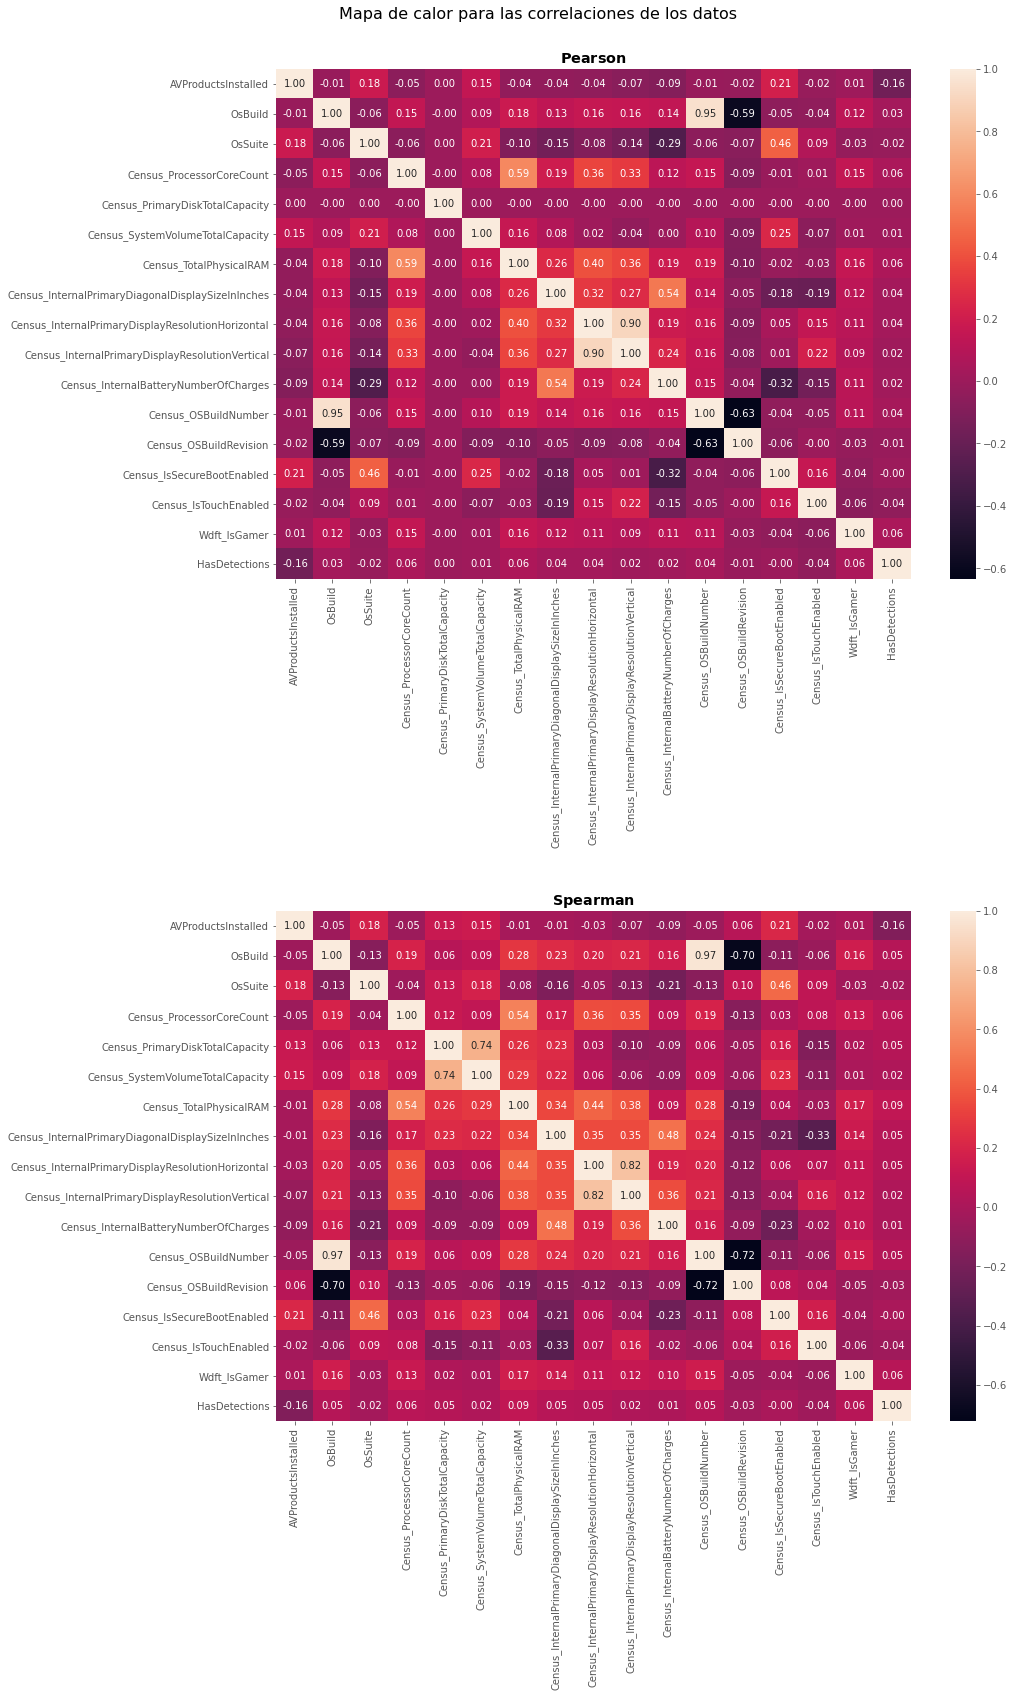

In [32]:
fig = plt.figure(figsize =(16,24))
plt.subplot(2,1,1)
sns.heatmap(numerical_data.corr(method ='pearson'),annot = True, fmt='.2f')
plt.title(r'$\bf{Pearson}$')
plt.subplot(2,1,2)
sns.heatmap(numerical_data.corr(method ='spearman'),annot = True, fmt='.2f')
plt.title(r'$\bf{Spearman}$')
fig.suptitle('Mapa de calor para las correlaciones de los datos', y=1, fontsize=16)
fig.tight_layout(pad=4.5)

Antes de entrar al análisis de los resultados, es importante tener en mente que la correlación de pearson tiene en cuenta el comportamiento de los datos atípicos de las variables, mientras que spearman no los considera en gran medida.

Con esto en mente, se puede ver que:
*  La variable ```Census_InternalPrimaryDisplayResolutionVertical``` y la variable ```Census_InternalPrimaryDisplayResolutionHorizontal``` están altamente relacionadas debido a los datos atípicos, puesto que cuando estos no se tienen en cuenta la correlación es mucho más baja.
*  Las variables ```OsBuild``` y ```Census_OSBuildNumber``` están altamente correlacionadas con ambas métricas de correlación. Adicionalmente, ambas tienen baja correlación con la variable objetivo y en general tienen las mismas correlaciones respecto a las otras variables, por lo que se podría considerar en **eliminar una de las dos**, puesto que no aportan información adicional la una con la otra.
*  Se puede ver que existe baja correlación entre todas las variables y la variable objetivo, lo que puede afectar considerablemente en un modelo lineal.

In [76]:
A_eliminar2 = ['Census_OSBuildNumber']

#### Análisis de variables categoricas

En esta sección se realiza el análisis descriptivo de las variables categoricas para poder tomar decisiones respecto a su transformación para poderlo incluir en el modelo.

Primero se realiza un análisis con la tabla que se ha venido utilizando previamente.

In [33]:
stats_numerical = mytable(categorical_data)
stats_numerical

,Variable,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de la categoria con más datos
0,EngineVersion,0.0,0.0,object,65,42.775118
1,AppVersion,0.0,0.0,object,104,60.089405
2,AvSigVersion,0.0,0.0,object,8474,1.184222
3,AVProductStatesIdentifier,0.0,0.0,object,25390,64.970671
4,CountryIdentifier,0.0,0.0,object,222,4.292392
5,CityIdentifier,0.0,0.0,object,103879,1.140770
6,GeoNameIdentifier,0.0,0.0,object,290,16.923977
7,LocaleEnglishNameIdentifier,0.0,0.0,object,275,23.363949
8,OsPlatformSubRelease,0.0,0.0,object,9,45.027568
9,OsBuildLab,0.0,0.0,object,553,42.196168


Se observa que muchas variables tienen miles de valores únicos, lo que podría ser un problema al momento de transformar las variables categoricas nominales a dummies. Se puede observar que muchas de estas variables corresponden a identificadores, las cuales deben ser tomadas como variables categoricas nominales. Teniendo en cuenta que los identificadores típicamente son excluidos de los análisis, puesto que no aportan información característica a los modelos, plantea la siguiente hipotesis:

*  No existe evidencia estadística que muestre relación de dependencia entre las variables categoricas identificadoras (aquellas que finalizan en "Identifier") y la variable objetivo ```HasDetections```.

Para dar respuesta a la hipótesis se evaluará mediante un análisis de contingencia a todas las variables. Las variables que muestren dependencia con la variable objetivo, se tendrán en cuenta para realizar un análisis más profundo para su transformación. Aquellas que no presenten evidencia estadística de dependencia, serán agregadas al grupo de variables a eliminar ```A_eliminar2```.

A continuación se define la función con la que se realizará el análisis de contingencia con una significancia del 0.1% y el p-value como métrica.

##### Análisis de contingencia

In [35]:
def contingency_analysis(data1,data2):
  Tabla_c = pd.crosstab(index=data1,columns=data2,margins=True)
  # Guardo el p-value en una variable para luego evaluarla dado las condiciones de abajo
  pvalue = chi2_contingency(Tabla_c)[1]
  # Usando prints y if para saber si acepto o no la hipotesis nula y 
  # asi concentrarme en el analisis 
  print("Hipotesis NULA:", "Las variables son independendientes")
  print("P-Value:", pvalue)

  pval = pvalue
  # nivel de significancia 0.001
  if pval > 0.001:
      print("Accept NULL hypothesis - Las variables son independientes es decir que no tienen relación entre ellas.")
  if pval <= 0.001:
      print("Reject NULL hypothesis - Las variables son dependientes.")

###### Variable: EngineVersion

In [41]:
contingency_analysis(categorical_data['EngineVersion'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: AppVersion

In [42]:
contingency_analysis(categorical_data['AppVersion'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: AvSigVersion

In [43]:
contingency_analysis(categorical_data['AvSigVersion'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: AVProductStatesIdentifier

In [44]:
contingency_analysis(categorical_data['AVProductStatesIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: CountryIdentifier

In [45]:
contingency_analysis(categorical_data['CountryIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: CityIdentifier

In [46]:
contingency_analysis(categorical_data['CityIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 1.0
Accept NULL hypothesis - Las variables son independientes es decir que no tienen relación entre ellas.


In [77]:
A_eliminar2.append('CityIdentifier')

###### Variable: GeoNameIdentifier

In [48]:
contingency_analysis(categorical_data['GeoNameIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: LocaleEnglishNameIdentifier

In [49]:
contingency_analysis(categorical_data['LocaleEnglishNameIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: OsPlatformSubRelease

In [50]:
contingency_analysis(categorical_data['OsPlatformSubRelease'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: OsBuildLab

In [51]:
contingency_analysis(categorical_data['OsBuildLab'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: SkuEdition

In [52]:
contingency_analysis(categorical_data['SkuEdition'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: IeVerIdentifier

In [53]:
contingency_analysis(categorical_data['IeVerIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_MDC2FormFactor

In [54]:
contingency_analysis(categorical_data['Census_MDC2FormFactor'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OEMNameIdentifier

In [55]:
contingency_analysis(categorical_data['Census_OEMNameIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OEMModelIdentifier

In [56]:
contingency_analysis(categorical_data['Census_OEMModelIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 3.690681916973295e-73
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_ProcessorManufacturerIdentifier

In [57]:
contingency_analysis(categorical_data['Census_ProcessorManufacturerIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 8.231050980491965e-187
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_ProcessorModelIdentifier

In [58]:
contingency_analysis(categorical_data['Census_ProcessorModelIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_PrimaryDiskTypeName

In [59]:
contingency_analysis(categorical_data['Census_PrimaryDiskTypeName'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_ChassisTypeName

In [60]:
contingency_analysis(categorical_data['Census_ChassisTypeName'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_PowerPlatformRoleName

In [61]:
contingency_analysis(categorical_data['Census_PowerPlatformRoleName'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OSVersion

In [62]:
contingency_analysis(categorical_data['Census_OSVersion'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OSBranch

In [63]:
contingency_analysis(categorical_data['Census_OSBranch'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OSEdition

In [64]:
contingency_analysis(categorical_data['Census_OSEdition'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OSSkuName

In [65]:
contingency_analysis(categorical_data['Census_OSSkuName'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OSInstallTypeName

In [66]:
contingency_analysis(categorical_data['Census_OSInstallTypeName'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OSInstallLanguageIdentifier

In [67]:
contingency_analysis(categorical_data['Census_OSInstallLanguageIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OSUILocaleIdentifier

In [68]:
contingency_analysis(categorical_data['Census_OSUILocaleIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_OSWUAutoUpdateOptionsName

In [69]:
contingency_analysis(categorical_data['Census_OSWUAutoUpdateOptionsName'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_ActivationChannel

In [70]:
contingency_analysis(categorical_data['Census_ActivationChannel'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_FirmwareManufacturerIdentifier

In [71]:
contingency_analysis(categorical_data['Census_FirmwareManufacturerIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Census_FirmwareVersionIdentifier

In [72]:
contingency_analysis(categorical_data['Census_FirmwareVersionIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


###### Variable: Wdft_RegionIdentifier

In [73]:
contingency_analysis(categorical_data['Wdft_RegionIdentifier'],numerical_data['HasDetections'])

Hipotesis NULA: Las variables son independendientes
P-Value: 0.0
Reject NULL hypothesis - Las variables son dependientes.


##### Eliminación de variables

Después de realizar el análisis de la relación lineal entre las variables, se decide eliminar las siguientes columnas adicionales: ```Census_OSBuildNumber```, ```CityIdentifier```.

In [78]:
A_eliminar2

['Census_OSBuildNumber', 'CityIdentifier']

In [79]:
for rem in A_eliminar2:
  train = train.drop(rem, axis=1)

Se verifica el nuevo tamaño del dataframe

In [80]:
train.shape

(7659039, 47)